In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
import time
from sklearn.metrics import explained_variance_score

In [2]:
class AP_GRU_Lag_Dual(nn.Module):
    def __init__(self, H_no, lag, device):
        super().__init__()
        
        self.H_no = H_no
        self.device = device
        
        self.rnn = nn.GRU((lag+1) * 2, H_no, batch_first=True)
        self.linear = nn.Linear(H_no, 1)
        
    def forward(self, V1, V2):
        #V is shape (batch, 50000, lag+1)
        V = torch.cat([V1, V2], -1)
        rnn_out, _ = self.rnn(V) #(batch,50000,H)
        rnn_out = rnn_out.reshape(-1,self.H_no)
        lin_out = self.linear(rnn_out).reshape(V.shape[0], -1) #(batch*50000,1)
        
        return lin_out

In [3]:
batch_size = 20
batch_length = int(50000 / 5 / 0.2)
H_no = 40
device = torch.device("cuda:1")
lag = 20

epoch_no = 400
iter_no = epoch_no * 980 // batch_size

#V = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/data/vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy").reshape(-1,50001)[:,:50000]
#V = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/data/V_diff_stimseed1.npy").reshape(-1,batch_length)
#V = np.load("/scratch/yjk27/CA1_clust4-60_AP/comb_pred/V_comb_pred_dend_interact_0.2ms.npy").reshape(-1,batch_length)
V1 = np.load("/scratch/yjk27/CA1_clust4-60/hand/gru_dend_s5_h20_Vall.npy").reshape(-1,batch_length)
V2 = np.load("/scratch/yjk27/CA1_clust4-60_AP/nona_pred/V_nona_pred_0.2ms.npy").reshape(-1,batch_length)
#V = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/whole_pred/V_whole_pred_0.2ms.npy").reshape(-1,batch_length)
S = np.load("/scratch/yjk27/CA1_clust4-60_AP/data/V_diff_stimseed1.npy").reshape(-1,batch_length)

V1-= np.mean(V1)
V2-= np.mean(V2)

V1 = torch.from_numpy(V1)
V2 = torch.from_numpy(V2)
S = torch.from_numpy(S)

V1_lag = np.zeros((V1.shape[0], V1.shape[1], lag)) #(lag,1000,50000)
V2_lag = np.zeros((V2.shape[0], V2.shape[1], lag)) #(lag,1000,50000)
for i in range(lag):
    V1_lag[:,i+1:,i] = V1[:,:-i-1]
    V2_lag[:,i+1:,i] = V2[:,:-i-1]

V1_lag = torch.from_numpy(V1_lag)
V2_lag = torch.from_numpy(V2_lag)
print(V1_lag.shape)

torch.Size([1000, 50000, 20])


In [4]:
V1_train = V1[:980].float()
V1_test = V1[980:].float().to(device)
V2_train = V2[:980].float()
V2_test = V2[980:].float().to(device)
S_train = S[:980].float()
S_test = S[980:].float().to(device)
V1_lag_train = V1_lag[:980].float()
V1_lag_test = V1_lag[980:].float().to(device)
V2_lag_train = V2_lag[:980].float()
V2_lag_test = V2_lag[980:].float().to(device)

train_idx = np.empty((epoch_no, 980))
for i in range(epoch_no):
    part_idx = np.arange(0,980,1)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.reshape(-1, batch_size)
train_idx = torch.from_numpy(train_idx).long()
print(train_idx.shape)

torch.Size([19600, 20])


In [5]:
model = AP_GRU_Lag_Dual(H_no, lag, device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

10121


In [6]:
#model.load_state_dict(torch.load("/scratch/yjk27/CA1_clust4-60_AP/comb_pred/gru_l20_h40_0.2ms_V.pt",
                     #map_location=device))

In [7]:
score_list = []

#for i in tnrange(iter_no):
for i in tnrange(10000):    
    s = time.time()
    model.train()
    optimizer.zero_grad()
    
    batch_idx = train_idx[i]
    batch_S = S_train[batch_idx].to(device)
    batch_V1 = V1_train[batch_idx].to(device)
    batch_V1_lag = V1_lag_train[batch_idx].to(device)
    batch_V2 = V2_train[batch_idx].to(device)
    batch_V2_lag = V2_lag_train[batch_idx].to(device)
    
    batch_V1_in = torch.zeros(batch_size, batch_length, lag+1).to(device)
    batch_V1_in[:,:,0] = batch_V1
    batch_V1_in[:,:,1:] = batch_V1_lag
    batch_V2_in = torch.zeros(batch_size, batch_length, lag+1).to(device)
    batch_V2_in[:,:,0] = batch_V2
    batch_V2_in[:,:,1:] = batch_V2_lag
    
    S_out = model(batch_V1_in, batch_V2_in)
    loss = torch.mean((S_out - batch_S) ** 2)
    
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 10)
    optimizer.step()
    
    step_time = time.time() - s
    
    if (i%50 == 49) or (i == 0):
        model.eval()
        V1_test_in = torch.zeros(batch_size, batch_length, lag+1).to(device)
        V1_test_in[:,:,0] = V1_test
        V1_test_in[:,:,1:] = V1_lag_test
        V2_test_in = torch.zeros(batch_size, batch_length, lag+1).to(device)
        V2_test_in[:,:,0] = V2_test
        V2_test_in[:,:,1:] = V2_lag_test
        
        test_S_out = model(V1_test_in, V2_test_in)
        test_loss = torch.mean((S_test - test_S_out) ** 2)
        test_var_exp = explained_variance_score(S_test.flatten().cpu().detach().numpy(),
                                                test_S_out.flatten().cpu().detach().numpy())
        
        score_list.append(test_loss.item())
        print(i, test_loss.item(), test_var_exp)

<ipython-input-7-99282bbeba95>:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(10000):


  0%|          | 0/10000 [00:00<?, ?it/s]

0 9.762406349182129 0.010455906391143799
49 9.533366203308105 0.031550049781799316
99 9.168319702148438 0.06864321231842041
149 8.956947326660156 0.0901532769203186
199 8.709667205810547 0.11534744501113892
249 8.740065574645996 0.11210435628890991
299 8.521679878234863 0.13461905717849731
349 8.366205215454102 0.1500365138053894
399 8.40752124786377 0.1458427906036377
499 8.273154258728027 0.15955543518066406
549 8.171164512634277 0.169843852519989
599 8.043549537658691 0.18281066417694092
649 7.958301067352295 0.19151490926742554
699 8.113773345947266 0.17567932605743408
749 8.03706169128418 0.18346750736236572
799 7.896110534667969 0.19779467582702637
849 7.745217323303223 0.2133198380470276
899 7.802095890045166 0.20738202333450317
949 7.7286376953125 0.21483439207077026
999 7.693795204162598 0.2183835506439209
1049 7.805130958557129 0.2070719599723816
1099 7.65424108505249 0.22237634658813477
1149 7.509191036224365 0.23709988594055176
1199 7.569436073303223 0.2310282588005066
1249

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4249 6.842719554901123 0.305194616317749
4299 6.705944061279297 0.31871533393859863
4349 6.8339409828186035 0.3057016134262085
4399 6.690744876861572 0.32027554512023926
4449 6.8127288818359375 0.30789798498153687
4499 6.720693111419678 0.3172159194946289
4549 6.74712610244751 0.3145532011985779
4599 6.723670959472656 0.31690794229507446
4649 6.704477787017822 0.31895798444747925
4699 6.682356357574463 0.3211062550544739
4749 6.798019886016846 0.30936765670776367
4799 6.749567985534668 0.31429171562194824
4849 6.847638130187988 0.3043489456176758
4899 6.750174045562744 0.31446003913879395
4949 6.766541004180908 0.3125638961791992
4999 6.9745869636535645 0.29157084226608276
5049 6.698330402374268 0.3196188807487488
5099 6.689277172088623 0.3204711079597473
5149 6.668368339538574 0.3225243091583252
5199 6.674951076507568 0.3218514919281006
5249 6.692258834838867 0.3200945258140564
5299 6.682743072509766 0.3212110996246338
5349 6.706640720367432 0.318633496761322


KeyboardInterrupt: 

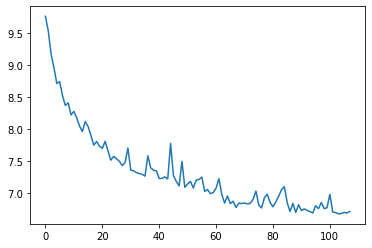

In [8]:
plt.plot(np.asarray(score_list)[:])


tensor(44.9315, device='cuda:1', grad_fn=<MaxBackward1>)


(23000.0, 28000.0)

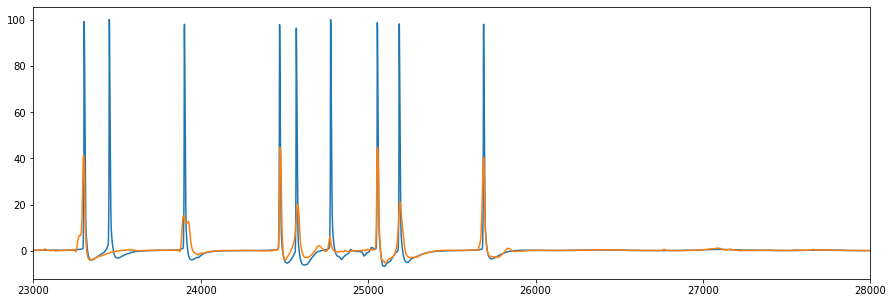

In [9]:
plt.figure(figsize = (15,5))
plt.plot(S_test[0].cpu().detach().numpy())
plt.plot(test_S_out[0].cpu().detach().numpy())
#plt.xlim(4500,5200)
#plt.ylim(-1,10)
print(torch.max(test_S_out))
plt.xlim(23000,28000)

In [10]:
test_S_out = test_S_out.cpu().detach().numpy()
test_S_out_next = np.zeros_like(test_S_out)
test_S_out_next[:,:-1] = test_S_out[:,1:]
test_S_out_thresh = np.zeros_like(test_S_out)

thresh = 15

for i in range(test_S_out.shape[0]):
    idx = np.where((test_S_out[i] < thresh) & (test_S_out_next[i] >= thresh))[0]
    test_S_out_thresh[i][idx] = 1

In [11]:
print(np.sum(test_S_out_thresh))

182.0


In [12]:
#torch.save(model.state_dict(), "/scratch/yjk27/CA1_clust4-60_AP/comb_pred/gru_dual_l20_h40_0.2ms_V_dend_interact.pt")

In [13]:
#np.save("/scratch/yjk27/CA1_clust4-60_AP/comb_pred/gru_dual_l20_h40_0.2ms_test_V_dend_interact.npy", test_S_out)
#np.save("/scratch/yjk27/CA1_clust4-60_AP/comb_pred/gru_dual_l20_h40_0.2ms_test_S_dend_interact.npy", test_S_out_thresh)